In [1]:

import torch,itertools,argparse,os,time,sys,random
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import argparse
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Categorical
from torch import Tensor
from typing import Type, Any, Callable, Union, List, Optional
from torchsummary import summary
from custom_train_tools import WaveNET, FClayer
import seaborn as sns

In [2]:
tr_model = torch.load("./res_model/Custom_model_80_80_80_2_2_2_0_fin.pth")
tr_model.eval()
mean = np.load('mean.npy')
std = np.load('std.npy')

In [3]:
# initialize

# initial setting

import numpy as np
import matplotlib.pyplot as plt

Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

dt = 0.1              # control frequency
tf = 40               # final time
g = 9.8
K_alt = .8*2          # hdot loop gain    
RoC = 20              # maximum rate of climb (max. of hdot)
AoA0 = -1.71*Deg2Rad     # zero lift angle of attack
Acc2AoA = 0.308333*Deg2Rad  # 1m/s^2 ACC corresponds to 0.308333deg AOA 
zeta_ap = 0.7         # pitch acceleration loop damping
omega_ap = 4          # pitch acceleration loop bandwidth

dist_sep = 100        # near mid-air collision range

t = np.arange(0, tf, dt)
N = len(t)





# hdot loop dynamics definition

def model(z, t, hdot_cmd):                          # computes state derivatives  
    a, adot, h, hdot, R = z                           # state vector: a (pitch acc), adot, h (alt), hdot, R (ground-track range)
    gamma=np.arcsin(hdot/Vm)                          # fight path angle
    ac = K_alt * (hdot_cmd - hdot) + g/np.cos(gamma)  # pitch acceleration command
    ac = np.clip(ac, -30, 30)                         # maneuver limit
  
    addot = omega_ap*omega_ap*(ac-a) - 2*zeta_ap*omega_ap*adot
    hddot = a*np.cos(gamma) - g
    Rdot = Vm*np.cos(gamma)
    return np.array([adot, addot, hdot, hddot, Rdot]) # returns state derivatives

In [4]:
hdot_cmd = 0
with torch.no_grad():
    hdot_res=[]
    hdot_res.append(0)
    time_temp=0
    errcmd=0
    insight=0


    hm0 = 1000                                                     # initial altitude
    Vm = np.random.uniform(2, 50)                                                       # initial speed
    Vt = np.random.uniform(2, 50)
    gamma0 = 0*Deg2Rad                                             # initial flight path angle
    Pm_NED = np.array([30*Vt - 30*Vm, 0, -hm0])                                # initial NED position
    Vm_NED = np.array([Vm*np.cos(gamma0), 0, -Vm*np.sin(gamma0)])  # initial NED velocity

    # state variable: [a, adot, h, hdot, R]
    X0 = np.array([g/np.cos(gamma0), 0, hm0, -Vm_NED[2], 30*Vt - 30*Vm])       # initial state vector

    ht0 = 1000 +10*np.random.randn()

    approach_angle = 180*Deg2Rad*(2*np.random.rand()-1)
    psi0 = np.pi + approach_angle + 2*np.random.randn()*Deg2Rad
    #psi0 = np.pi*7/6
    psi0 = np.arctan2(np.sin(psi0), np.cos(psi0))

    Pt_N = 30*Vt*(1+np.cos(approach_angle))
    Pt_E = 30*Vt*np.sin(approach_angle)
    Pt_D = -ht0
    Pt_NED = np.array([Pt_N, Pt_E, Pt_D])                             # initial NED position
    Vt_NED = np.array([Vt*np.cos(psi0), Vt*np.sin(psi0), 0])       # initial NED velocity


    # initialize variables
    X = np.zeros((N,len(X0)))
    X[0,:] = X0
    dotX_p = 0

    Y = np.zeros((N,8))                       # print-out data
    theta0 = gamma0 + X0[0]*Acc2AoA + AoA0 # initial pitch angle

    DCM = np.zeros((3,3))                      # initial DCM NED-to-Body
    DCM[0,0] =  np.cos(theta0)
    DCM[0,2] = -np.sin(theta0)
    DCM[1,1] =  1
    DCM[2,0] =  np.sin(theta0)
    DCM[2,2] =  np.cos(theta0)

    Pr_NED = Pt_NED - Pm_NED                   # relative NED position
    Vr_NED = Vt_NED - Vm_NED                   # relative NED velosity

    Pr_Body = np.dot(DCM, Pr_NED)              # relative position (Body frame)

    # radar outputs
    r = np.linalg.norm(Pr_Body)                # range
    vc = -np.dot(Pr_NED, Vr_NED)/r             # closing velocity
    elev = np.arctan2(Pr_Body[2], Pr_Body[0])  # target vertival look angle (down +)
    azim = np.arctan2(Pr_Body[1], Pr_Body[0]/np.cos(theta0))  # target horizontal look angle (right +)

    los = theta0 - elev                        # line of sight angle
    dlos = 0
    daz = 0

    Y[0,:] = np.array([*Pm_NED, *Pt_NED,r,hdot_cmd]) 
    # static variables
    los_p = los
    dlos_p = dlos
    azim_p = azim
    daz_p = daz
    cmd_hold = False
    cmd_start = False
    direction_avoid = 0
    hdot_cmd = 0
    hdot = 0
    gamma = gamma0
    count_change_hdot=0
    count_change_hdot2=0
    count_vert_col=0
    err=0
    vc0=vc

    # main loop
    for k in range(N-1):  
        ##############################################################################
        # UPDATE ENVIRONMENT AND GET OBSERVATION

        # update environment
        # adams-bashforth 2nd order integration
        dotX = model(X[k,:], t[k], hdot_cmd)
        X[k+1,:] = X[k,:] + 0.5*(3*dotX-dotX_p)*dt
        dotX_p = dotX

        Pt_NED = Pt_NED + Vt_NED*dt        # target position integration

        # get observation

        a, adot, h, hdot, R = X[k+1,:]

        gamma = np.arcsin(hdot/Vm)
        theta = gamma + a*Acc2AoA + AoA0

        DCM = np.zeros((3,3))
        DCM[0,0] =  np.cos(theta)
        DCM[0,2] = -np.sin(theta)
        DCM[1,1] =  1
        DCM[2,0] =  np.sin(theta)
        DCM[2,2] =  np.cos(theta)

        Pm_NED = np.array([R, 0, -h]) 
        Vm_NED = np.array([Vm*np.cos(gamma), 0, -Vm*np.sin(gamma)])

        Pr_NED = Pt_NED - Pm_NED
        Vr_NED = Vt_NED - Vm_NED

        Pr_Body = np.dot(DCM, Pr_NED)

        r = np.linalg.norm(Pr_Body)
        vc = -np.dot(Pr_NED, Vr_NED)/r 
        elev = np.arctan2(Pr_Body[2], Pr_Body[0])
        azim = np.arctan2(Pr_Body[1], Pr_Body[0]/np.cos(theta))

        psi = np.arctan2(Vt_NED[1], Vt_NED[0])

        # los rate and az rate estimation
        los = theta - elev

        dlos = ( 30*(los-los_p) + 0*dlos_p ) / 3 # filtered LOS rate, F(s)=20s/(s+20)
        daz = ( 30*(azim-azim_p) + 0*daz_p ) / 3 # filtered azim rate, F(s)=20s/(s+20)

        los_p = los
        dlos_p = dlos
        azim_p = azim
        daz_p = daz

        # estimate closest approach
        min_dist_vert = r*r/vc*dlos
        min_dist_horiz = r*r/vc0*daz

        # estimate cruise distance
        dist_cruise = r*los
        t_col = -np.dot(Vr_NED,Pr_NED)/np.linalg.norm(Vr_NED)/np.linalg.norm(Vr_NED)
        closest_NED = Pr_NED + Vr_NED*t_col
        zem = np.linalg.norm(closest_NED)
        zem_v2 = -closest_NED[-1]    
        zem_h2 = zem                  

        Vm_NED_c = np.array([Vm_NED[0], Vm_NED[1], 0])
        Vm_NED_c = Vm_NED_c*np.linalg.norm(Vm_NED)/np.linalg.norm(Vm_NED_c)
        Vr_NED_c = Vt_NED - Vm_NED_c
        t_col_c = -np.dot(Vr_NED_c,Pr_NED)/np.linalg.norm(Vm_NED_c)/np.linalg.norm(Vm_NED_c)
        closest_NED_c = Pr_NED + Vr_NED_c*t_col_c
        crm_c = np.linalg.norm(closest_NED_c)
        crm_v2 = -closest_NED_c[-1]
        ##############################################################################
        # COMPUTE ACTION (BEGIN) (for testing model)
        if k > 5 and r > dist_sep:
            insight += 1
            data = torch.tensor(((np.array([r, vc, azim, los, daz, dlos])-mean)/std).astype(np.float32)).cuda()
            output = tr_model(data)
            predicted = torch.argmax(output).item()
            if predicted == 0:
                hdot_cmd = 0
            if predicted == 1:
                if hdot_cmd != -20:
                    count_change_hdot += 1
                hdot_cmd = -20
            if predicted == 2:
                if hdot_cmd != 20:
                    count_change_hdot += 1
                hdot_cmd=20

        Y[k+1,:] = np.array([*Pm_NED, *Pt_NED,r,hdot_cmd]) 

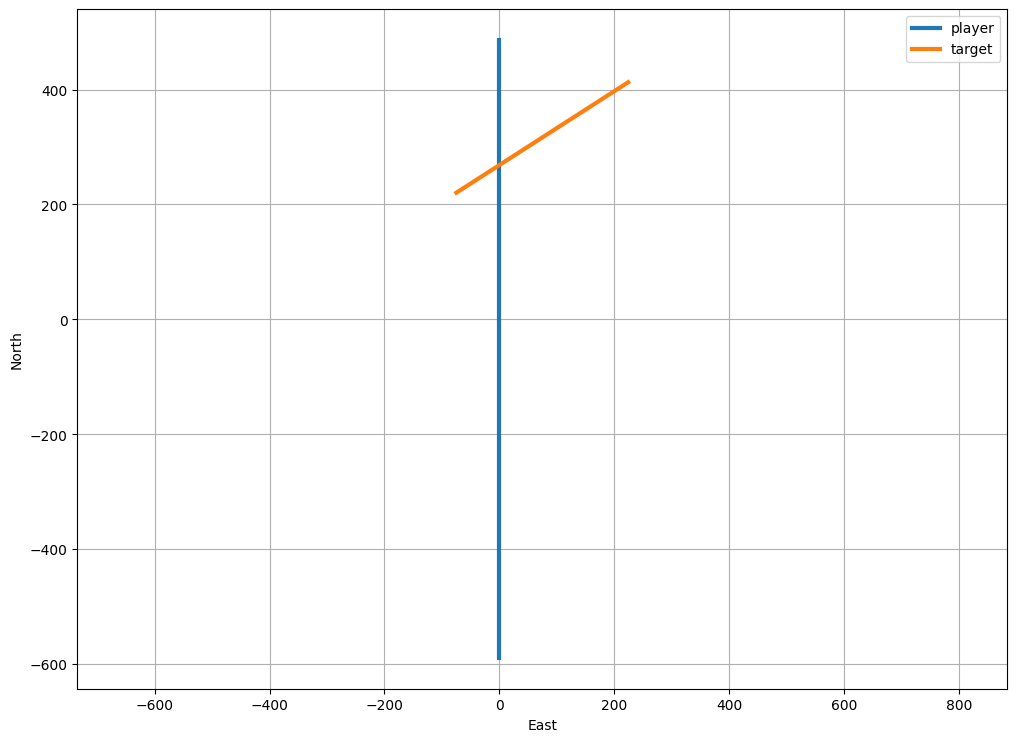

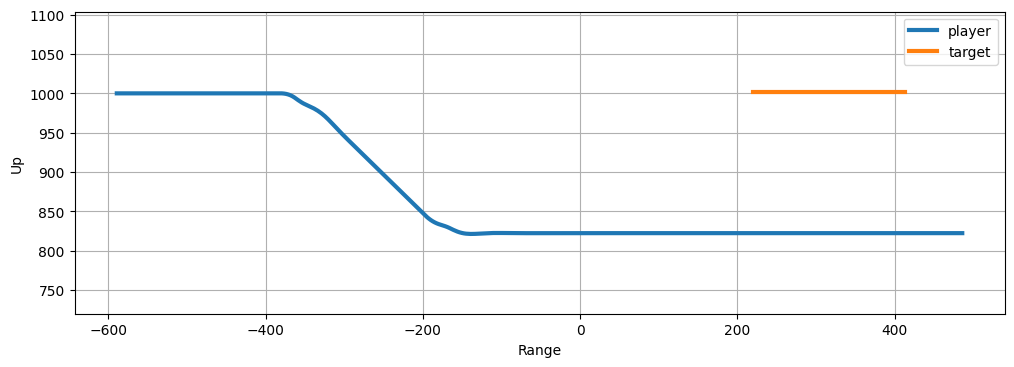

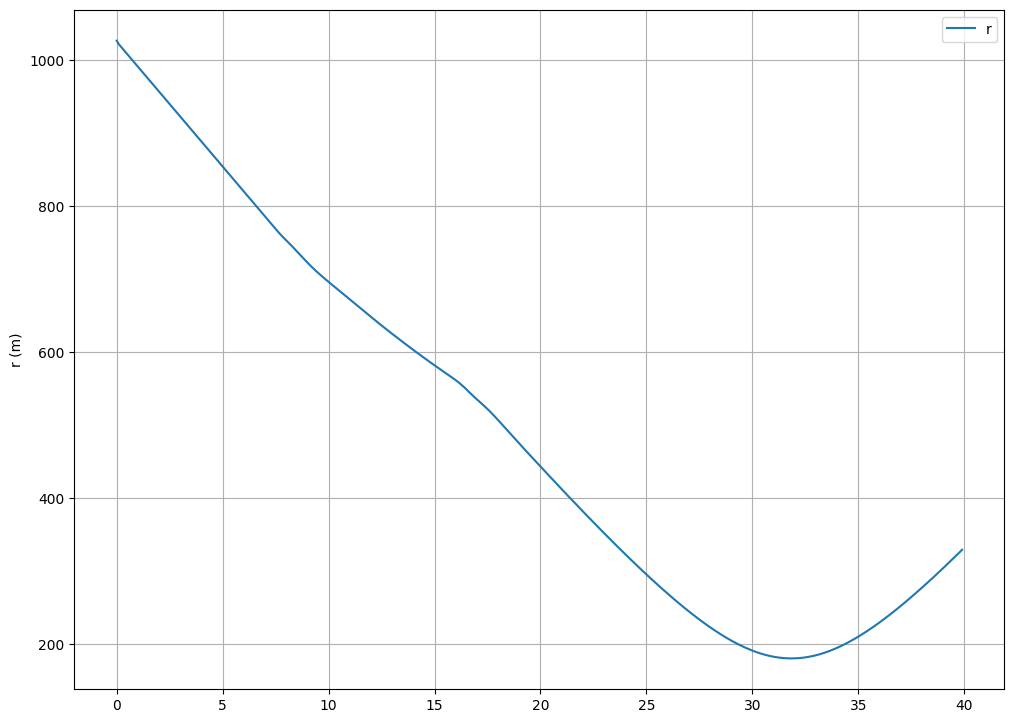

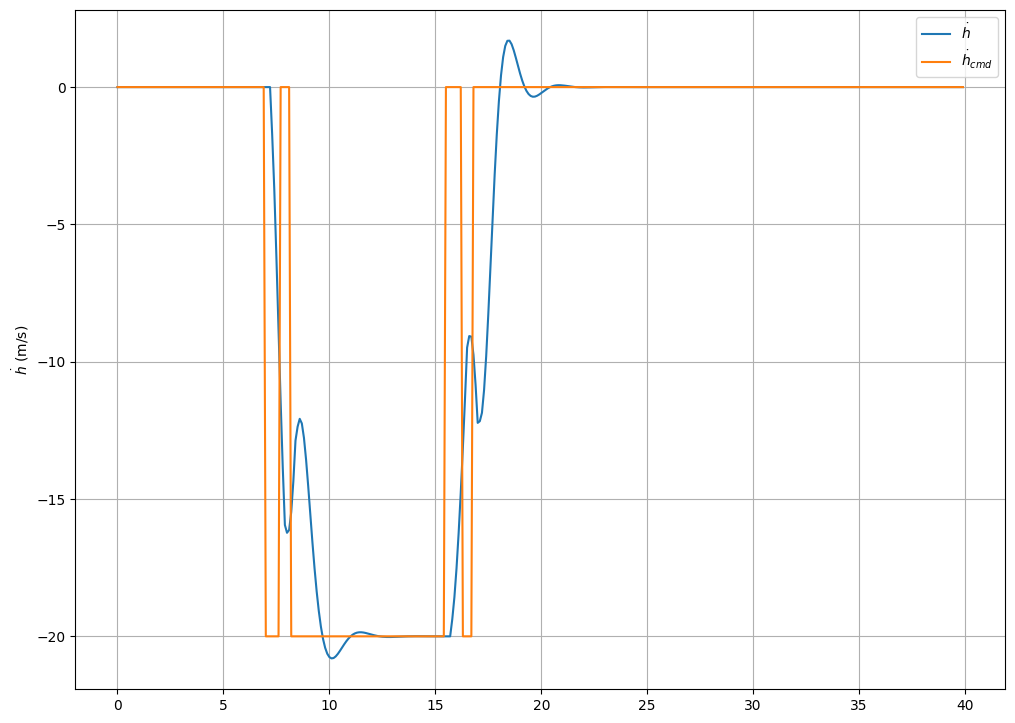

In [8]:
plt.figure(figsize=(12,9), dpi=100)
plt.plot(Y[:,1], Y[:,0], label='player', linewidth=3)
plt.plot(Y[:,4], Y[:,3], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,4), dpi=100)
plt.plot(Y[:,0], -Y[:,2], label='player', linewidth=3)
plt.plot(Y[:,3], -Y[:,5], label='target', linewidth=3)
plt.xlabel('Range')
plt.ylabel('Up')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(t, Y[:,-2], label=r'r')
plt.ylabel('r (m)'), plt.grid(), plt.legend()
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(t, X[:,3], label=r'$\dot{h}$')
plt.plot(t, Y[:,-1], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}$ (m/s)'), plt.grid(), plt.legend()
plt.show()


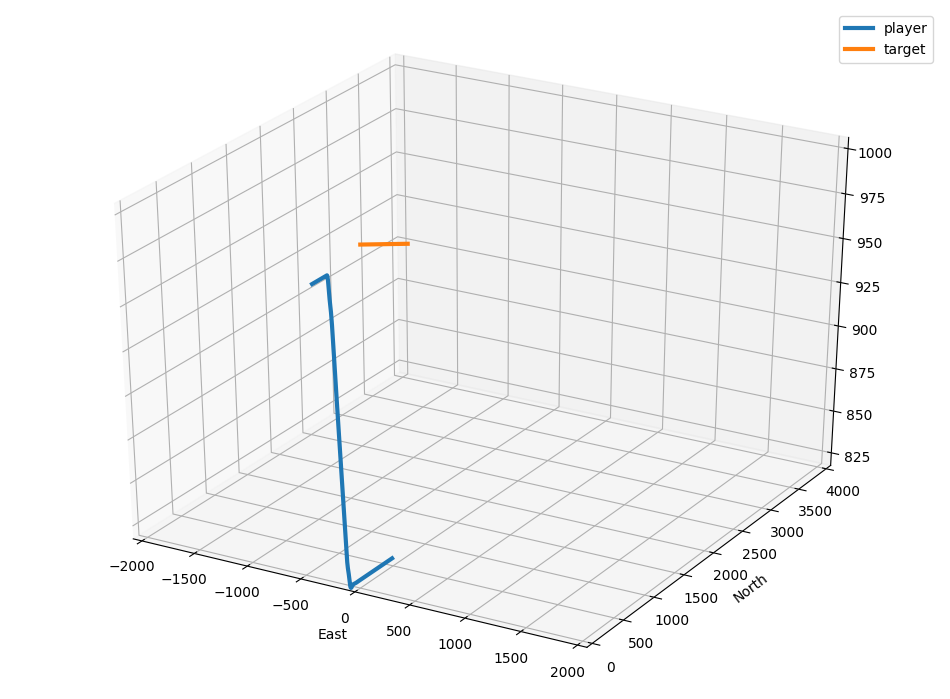

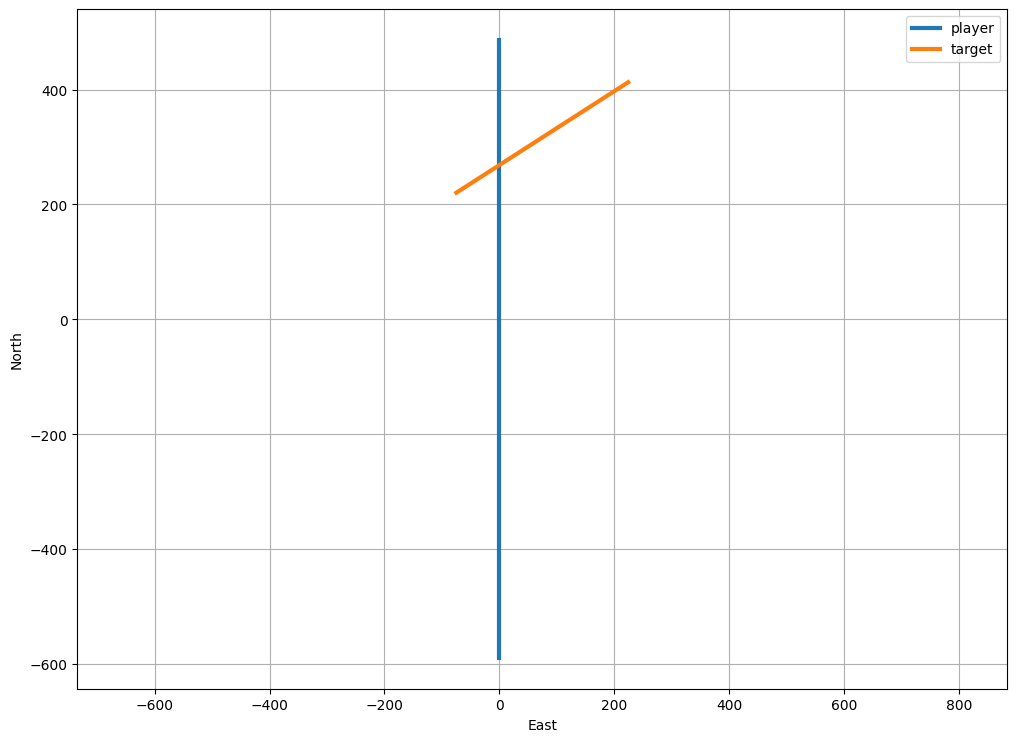

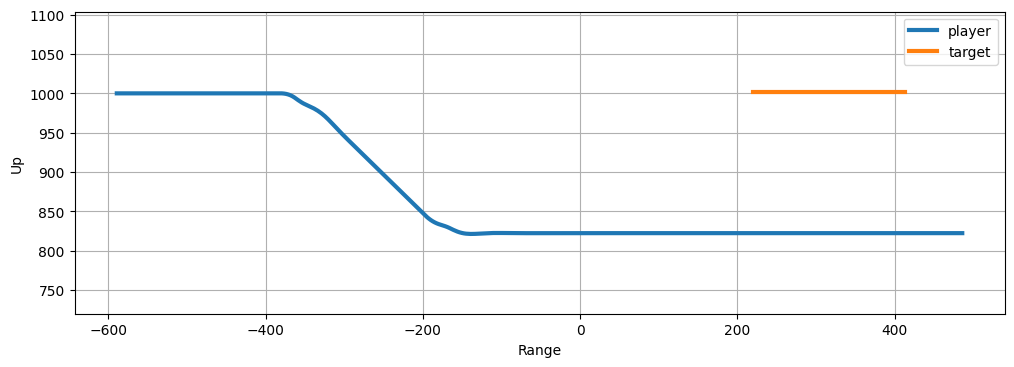

In [9]:
# trajectory plots

from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,9), dpi=100)
plt.gca(projection='3d')
plt.plot(Y[:,1], Y[:,0], -Y[:,2], label='player', linewidth=3)
plt.plot(Y[:,4], Y[:,3], -Y[:,5], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.xlim(-2000,2000)
plt.ylim(0,4000)
plt.legend()
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(Y[:,1], Y[:,0], label='player', linewidth=3)
plt.plot(Y[:,4], Y[:,3], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,4), dpi=100)
plt.plot(Y[:,0], -Y[:,2], label='player', linewidth=3)
plt.plot(Y[:,3], -Y[:,5], label='target', linewidth=3)
plt.xlabel('Range')
plt.ylabel('Up')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()